# Abstract:

Malicious URLs pose a huge risk on the Internet. They pose as legitimate URLs to lead unsuspecting users to provide sensitive information. They can also download malware onto the user's device. This notebook uses a powerful transformer model called BERT to perform classification on the URLs.

# Related Work:

There are various existing methods for detecting and flagging malicious URLs. 

One method uses a blacklist, which  holds previously flagged malicious URLs. The drawback of this approach is its lack of generalization to new URLs. It always has to add new URLs since it just performs pattern matching. []

Another method uses heuristics, which are intuitive or rule-of-thumb methods.  These methods cannot be specifically quantified or formalized. []

## Setup

In [36]:
import math

import numpy as np
import pandas as pd
import torch

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

## Reading in Data

For this project, we are using a dataset from Kaggle containing 651,191 URLs and 4 classes (benign, defacement, phishing, and malware). []

In [4]:
original_df = pd.read_csv("malicious_phish.csv")
original_df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


The Kaggle data card outlines the distribution of the labels. The figure below shows the unbalanced distribution of classes. []

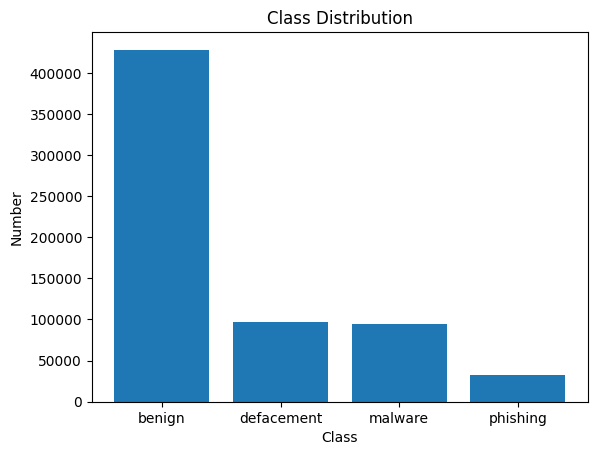

In [37]:
plt.bar(["benign", "defacement", "malware", "phishing"], [428103, 96547, 94111, 32520])
plt.xlabel("Class")
plt.ylabel("Number")
plt.title("Class Distribution")
plt.show()

## Sampling the Data

I am taking a sample of the data to use in order to reduce computational complexity.

There are two methods shown below. The first method uses a percentage, while the other method uses an explicit number of samples.

In [10]:
# PERCENTAGE = 0.005
# df = original_df.sample(frac=PERCENTAGE, replace=False, random_state=42)

In [11]:
NUM_SAMPLES = 1000
df = original_df.sample(n=NUM_SAMPLES, replace=False, random_state=42)

In [12]:
df.shape

(1000, 2)

## BERT Setup

I am loading the pre-trained model along with its tokenizer here.

BERT (Bi-Directional Pre-Trained Transformer) uses the encoder part of a transformer. This model is pre-trained under the MLM (masked language modeling) task on lots of data from the Internet. Therefore, the model has a good understanding of English grammar.

BERT is not trained in the classification task I want to perform, so I have to perform **fine-tuning** for BERT on a sample of the URL data.

This model does not need a large amount of data to fine-tune.

Each model has its own tokenizer because they each accept data in their own specific formats.

I am running this model on the SJSU HPC (High-Performance Cluster) servers, so I had to download the model from HuggingFace to use locally. 

In [13]:
MODEL = "./bert-base-uncased/"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./bert-base-uncased/ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Loading Dataset

Currently, the dataset is loaded into a Pandas dataframe. It has to be loaded into a HuggingFace Dataset format in order to provide the full range of functionalities.

In [17]:
dataset = Dataset.from_pandas(df)

In [18]:
dataset = dataset.remove_columns(["__index_level_0__"])

In [19]:
dataset = dataset.class_encode_column("type")

Casting to class labels: 100%|███| 1000/1000 [00:00<00:00, 185375.41 examples/s]


BERT also expects the columns to be named "text" and "label".

In [20]:
dataset = dataset.rename_column("url", "text")
dataset = dataset.rename_column("type", "label")

In [25]:
target_labels = dataset.features["label"].names

In [26]:
target_labels

['benign', 'defacement', 'malware', 'phishing']

In [27]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

## BERT Tokenization

The URLs need to be converted into numbers, so I use the BERT tokenizer here to convert the inputs into a format that BERT can recognize.

In [28]:
def tokenize(data):
    return tokenizer(data["text"], padding="max_length", return_tensors="pt")

In [29]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 1667.12 examples/s]


In [30]:
tokenized_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

## Dataset Split

I am splitting the dataset here into **train**, **validation**, and **test** sets.

In [21]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)

In [22]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [23]:
train_eval_dataset = split_dataset["train"]

In [24]:
train_eval_split_dataset = train_eval_dataset.train_test_split(test_size=0.1)

In [25]:
train_dataset = train_eval_split_dataset["train"]

In [26]:
eval_dataset = train_eval_split_dataset["test"]

In [27]:
test_dataset = split_dataset["test"]

In [28]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 810
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 90
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 100
 }))

## BERT Fine-Tuning

This object specifies the training configuration arguments.

In [118]:
training_args = TrainingArguments(output_dir="results", 
                                  num_train_epochs=5,
                                  logging_steps=1,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=8,
                                  weight_decay=0,
                                  evaluation_strategy="epoch")

I am using cross-entropy loss here because this is a multi-class classification problem

In [119]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sum = 0
    for i in range(len(labels)):
        raw_logits = logits[i]
        
        exp_logits = np.exp(raw_logits)
        norm_logits = exp_logits / np.sum(exp_logits, axis=0)
        chosen_value = norm_logits[labels[i]]
        
        sum += np.log(chosen_value)
    sum /= -len(labels)
    return {"cross_entropy": sum}

In [120]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

/home/012392471/miniconda3/envs/security/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [121]:
trainer.train()

Epoch,Training Loss,Validation Loss,Cross Entropy
1,0.000000,1.821026,1.821026
2,0.000000,1.924675,1.924676
3,0.000000,1.988559,1.988559
4,0.000000,2.020792,2.020792
5,0.000000,2.022616,2.022616


TrainOutput(global_step=510, training_loss=1.9064715683086876e-07, metrics={'train_runtime': 254.5009, 'train_samples_per_second': 15.914, 'train_steps_per_second': 2.004, 'total_flos': 1065618909388800.0, 'train_loss': 1.9064715683086876e-07, 'epoch': 5.0})

## Predictions

In [122]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [123]:
true_labels = test_dataset["label"]

In [125]:
conf_mat = confusion_matrix(true_labels, predicted_labels, labels=np.arange(4))

It is important to see how the model performs across the different classes. A single accuracy value averaged across all of the classes provides an insufficient evaluation of the model's performance. As mentioned earlier, there is a class imbalance. If the model boasts an accuracy of 90%, it does not provide information on the under-represented classes. Therefore, it is vital to look at the precision, recall, and F-1 score for each class. These metrics are detailed below in the classification report.

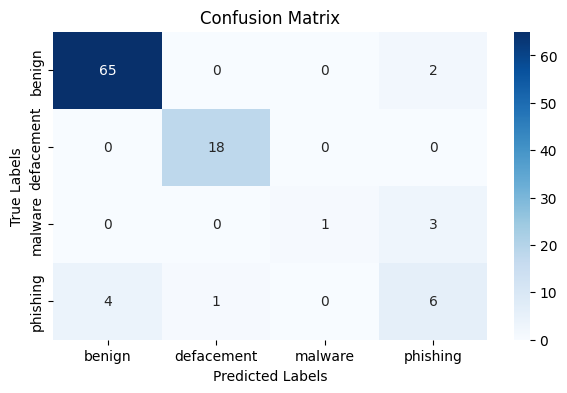

In [126]:
plt.figure(figsize=(7, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [127]:
report = classification_report(true_labels, predicted_labels, labels=np.arange(4), target_names=target_labels, output_dict=False)
print(report)

              precision    recall  f1-score   support

      benign       0.94      0.97      0.96        67
  defacement       0.95      1.00      0.97        18
     malware       1.00      0.25      0.40         4
    phishing       0.55      0.55      0.55        11

    accuracy                           0.90       100
   macro avg       0.86      0.69      0.72       100
weighted avg       0.90      0.90      0.89       100



# Conclusion

BERT takes more computational power but can learn well with less samples.

# References

[1]